In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from datasets import load_dataset

dataset=load_dataset("lukebarousse/data_jobs")
df=dataset["train"].to_pandas()

df["job_posted_date"]=pd.to_datetime(df["job_posted_date"])
df["job_skills"]=df["job_skills"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


In [20]:
#Filter Df for DAs in the US:
df_DA_US=df[(df["job_title_short"]=="Data Analyst")&(df["job_country"]=="United States")].copy()

In [22]:
#Remove NaNs from salary column:
df_DA_US=df_DA_US.dropna(subset=["salary_year_avg"])

In [ ]:
#Another way - If we wanted to filter df for DAs in the US, addressing possible extra spaces and lower/upper cases and drop NaNs of salary:

# df_DA_US = (
#     df[
#         (df["job_title_short"].str.strip().str.lower() == "data analyst")
#         & (df["job_country"].str.strip().str.lower() == "united states")
#     ]
#     .dropna(subset=["salary_year_avg"])
#     .copy()
# )


In [24]:
#Explode job_skills:
df_DA_US_exploded=df_DA_US.explode("job_skills")
#check:
df_DA_US_exploded[["salary_year_avg","job_skills"]].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


In [28]:
#Group by jobs skills based on median salary and count:
df_DA_skills = df_DA_US_exploded.groupby("job_skills")["salary_year_avg"].agg(["count", "median"]).sort_values(by="count", ascending=False)
#Rename the columns count and median:
df_DA_skills = df_DA_skills.rename(columns={"count":"skill_count","median":"median_salary"})
df_DA_skills


,skill_count,median_salary
job_skills,,
sql,2508,91000.0
excel,1808,84392.0
python,1431,97500.0
tableau,1364,92875.0
sas,926,90000.0
...,...,...
couchbase,1,160515.0
chainer,1,100000.0
chef,1,85000.0


In [ ]:
#Another way - Could've renamed the columns when i created them:

#inside agg():
# df_DA_skills = ( 
#     df_DA_US_exploded 
#     .groupby("job_skills")["salary_year_avg"] 
#     .agg(skill_count="count", median_salary="median") 
#     .sort_values(by="skill_count", ascending=False) 
#     )

# or after agg():

# df_DA_skills = (
#     df_DA_US_exploded
#         .groupby("job_skills")["salary_year_avg"]
#         .agg(["count", "median"])
#         .rename(columns={"count": "skill_count", "median": "median_salary"})
#         .sort_values(by="skill_count", ascending=False)
# )


In [33]:
#We need to get the percentage so we need to know how many job postings there are:
DA_job_count=len(df_DA_US)

#another way would be df_DA_US.index.size

In [34]:
#Create the skill percent column:
df_DA_skills["skill_percent"]=df_DA_skills["skill_count"]/DA_job_count * 100

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.0,57.655172
excel,1808,84392.0,41.563218
python,1431,97500.0,32.896552
tableau,1364,92875.0,31.356322
sas,926,90000.0,21.287356
...,...,...,...
couchbase,1,160515.0,0.022989
chainer,1,100000.0,0.022989
chef,1,85000.0,0.022989


In [35]:
#We don't want all the skills, so we will define a cut-off percentage, to drop any skills below that %
skill_percent=5

df_DA_skills_high_demand=df_DA_skills[df_DA_skills["skill_percent"]>skill_percent]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


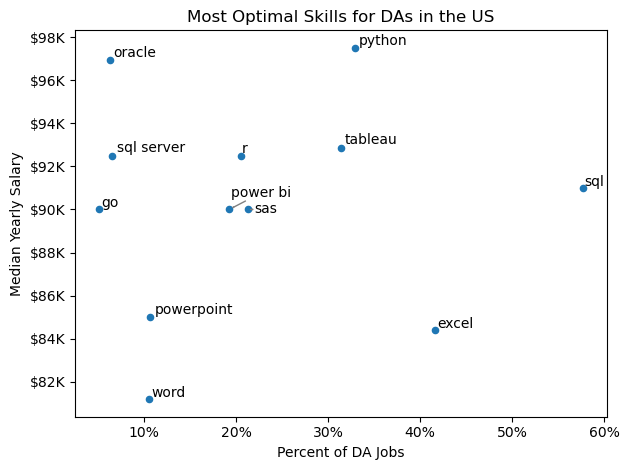

In [41]:
#Using the code from lesson 16_Matplotlib_Advanced Customization:

from adjustText import adjust_text

df_DA_skills_high_demand.plot(kind='scatter', x='skill_percent', y='median_salary')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of DA Jobs')
plt.ylabel('Median Yearly Salary')
plt.title("Most Optimal Skills for DAs in the US")

ax=plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
from matplotlib.ticker import PercentFormatter
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()

In [42]:
df["job_type_skills"]

0                                                      None
1         {'analyst_tools': ['power bi', 'tableau'], 'pr...
2         {'analyst_tools': ['dax'], 'cloud': ['azure'],...
3         {'cloud': ['aws'], 'libraries': ['tensorflow',...
4         {'cloud': ['oracle', 'aws'], 'other': ['ansibl...
                                ...                        
785736    {'os': ['linux', 'unix'], 'other': ['kubernete...
785737    {'analyst_tools': ['sas', 'excel'], 'programmi...
785738           {'analyst_tools': ['powerpoint', 'excel']}
785739    {'cloud': ['aws', 'snowflake', 'azure', 'redsh...
785740                {'cloud': ['aws'], 'other': ['flow']}
Name: job_type_skills, Length: 785741, dtype: object

In [ ]:
#Calor code by the core technologies
#Inside the OG df we have a column "job_type_skills" which is composed of a dictionary with:
#   keys - analyst_tools, programming, async, cloud, etc
#   values - lists of python, sql, tableau, etc

#Get those to a new df:
df_technology=df["job_type_skills"].copy()
#output:
# 0                                                      None
# 1         {'analyst_tools': ['power bi', 'tableau'], 'pr...
# 2         {'analyst_tools': ['dax'], 'cloud': ['azure'],...
# 3         {'cloud': ['aws'], 'libraries': ['tensorflow',...
# 4         {'cloud': ['oracle', 'aws'], 'other': ['ansibl...
# ...

#Remove duplicates:
df_technology=df_technology.drop_duplicates()
#not really necessary since the rest of the code will deal with duplicates, but this is essentially saving
#us time and processing power by not processing the same dictionary twice.

#Remove NaNs:
df_technology=df_technology.dropna()

#Combine all dictionaries into one:
technology_dict={}

for row in df_technology: #go through each row of the df_technology.
# each row is a string like "{'cloud': ['aws'], 'libraries': ['tensorflow']}"
    row_dict=ast.literal_eval(row) #convert each row, that are strings, to dictionaries.
    for key,value in row_dict.items():
        if key in technology_dict: #if key already exists in technology_dict, add value to existing value
            technology_dict[key]+= value
#suppose technology_dict = {'cloud': ['aws']} and value = ['azure']
#then technology_dict['cloud'] += ['azure'] will result {'cloud': ['aws', 'azure']}
# += on lists means extend - the same as: technology_dict['cloud'].extend(value)
#list concatenation:  ['aws'] + ['azure', 'gcp'] = ['aws', 'azure', 'gcp']

        else: #if key does not exist in technology_dict, add key and value
            technology_dict[key]=value
#This means Create a new key in the dictionary and assign this list to it
#technology_dict['libraries'] = ['tensorflow'] so we would get: {'cloud': ['aws'], 'libraries': ['tensorflow']}
#this is not appending - it's creating a new key-value pair

#remove duplicates by converting values to set then back to list:
for key, value in technology_dict.items():
    technology_dict[key]=list(set(value))
#we need key and value in this loop because .items() returns both
#we need key to know which category to update, and value to clean the skill list
#set(value) - Removes duplicate skills within each category
#we are not checking for duplicate keys - it's removing duplicate skills within each category's list
#the loop is iterating over: 
# {
#   'cloud': ['aws', 'aws', 'azure'],
#   'libraries': ['tensorflow', 'tensorflow']
# }
#So the iteration is: key = 'cloud' and value = ['aws', 'aws', 'azure']
#What set does is {'aws', 'azure'}, removes the duplicate values
#Then we convert them to list ['aws', 'azure'] and replace the old list for that particular key:
#technology_dict[key] = ['aws', 'azure']


technology_dict

{'analyst_tools': ['ms access',
  'datarobot',
  'ssis',
  'spreadsheet',
  'looker',
  'ssrs',
  'spss',
  'power bi',
  'sap',
  'word',
  'powerpoint',
  'esquisse',
  'sas',
  'nuix',
  'powerbi',
  'sheets',
  'alteryx',
  'qlik',
  'microstrategy',
  'visio',
  'msaccess',
  'sharepoint',
  'dax',
  'outlook',
  'excel',
  'tableau',
  'splunk',
  'cognos'],
 'programming': ['sql',
  'c++',
  'kotlin',
  'haskell',
  'c',
  'ocaml',
  'powershell',
  'matlab',
  'javascript',
  'php',
  'dart',
  'groovy',
  'cobol',
  'css',
  'no-sql',
  't-sql',
  'clojure',
  'delphi',
  'shell',
  'python',
  'java',
  'r',
  'nosql',
  'bash',
  'mongodb',
  'sas',
  'assembly',
  'julia',
  'solidity',
  'go',
  'rust',
  'scala',
  'crystal',
  'vb.net',
  'erlang',
  'apl',
  'mongo',
  'lua',
  'typescript',
  'pascal',
  'perl',
  'c#',
  'swift',
  'vba',
  'visual basic',
  'f#',
  'fortran',
  'elixir',
  'golang',
  'lisp',
  'sass',
  'ruby',
  'html',
  'visualbasic',
  'objectiv

In [ ]:
#Turn this list into a df:
df_technology=pd.DataFrame(list(technology_dict.items()), columns=['technology','skills'])

#technology_dict.items() produces a view of key–value pairs:
# dict_items([
#     ('cloud', ['aws', 'azure']),
#     ('libraries', ['pandas', 'tensorflow']),
#     ('analyst_tools', ['excel', 'power bi'])
# ])
#Each element is a tuple: ('cloud', ['aws', 'azure'])
#list(technology_dict.items()) turns those into a list of tuples:
# [
#     ('cloud', ['aws', 'azure']),
#     ('libraries', ['pandas', 'tensorflow']),
#     ('analyst_tools', ['excel', 'power bi'])
# ]

#With 
# pd.DataFrame(
#     list(technology_dict.items()),
#     columns=['technology', 'skills']
# )
#Pandas (pd.dataframe()) sees a list of tuples and thinks that each tuple (with 2 elements) is one row.
#The 1st element of each tuple goes in the first column
#The 2nd element of each tuple goes in the second column

#this one line is equivalent to this:

# rows = []

# for tech, skills in technology_dict.items():
#     rows.append([tech, skills])

# df_technology = pd.DataFrame(rows, columns=['technology', 'skills'])


#Explode the skills:
df_technology=df_technology.explode("skills")

df_technology

,technology,skills
0,analyst_tools,ms access
0,analyst_tools,datarobot
0,analyst_tools,ssis
0,analyst_tools,spreadsheet
0,analyst_tools,looker
...,...,...
9,sync,twilio
9,sync,mattermost
9,sync,slack
9,sync,google chat


In [45]:
#Lets merge this new df with the df we had with just skill_count, median_salary and skill_percent:
df_plot=df_DA_skills_high_demand.merge(df_technology, left_on="job_skills", right_on="skills")
#need to specify left on and right on because the columns have different names


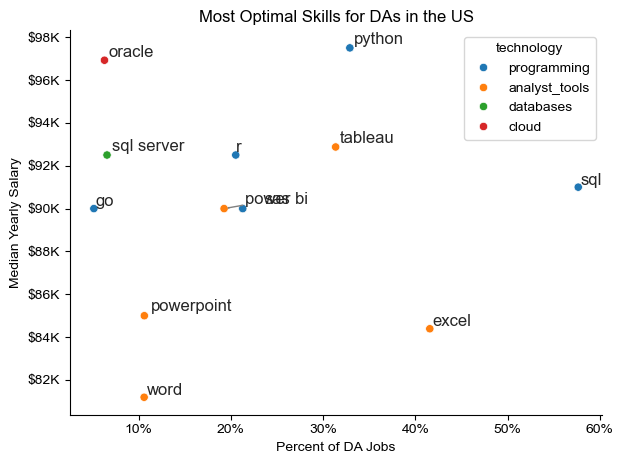

In [ ]:
from adjustText import adjust_text

sns.scatterplot(
    data=df_plot,
    x="skill_percent",
    y="median_salary",
    hue="technology"
)

sns.despine()
sns.set_theme(style="ticks")

# Prepare texts for adjustText
texts = []
for _, row in df_plot.iterrows():
     texts.append(
         plt.text(row['skill_percent'], row['median_salary'], row['skills'])
     )

#We could've used the same as before:
# for i, txt in enumerate(df_DA_skills_high_demand.index):
#     texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))



#Explanation: 
#.This code adds text labels to points on a matplotlib plot and saves those text objects in a
#list called "texts".
#.enumerate goes through the index of the df_DA_skills_high_demand which is python, sql, excel, etc and 
#gives us the row number i and the index value txt.
#.plt.text(x,y,txt) draws the text on a plot and returns a Text object. 
#   x- skill percentage     y- median salary    txt- skill name (label)
#.df_DA_skills_high_demand['skill_percent'].iloc[i] - gets the x position for row i
#.df_DA_skills_high_demand['median_salary'].iloc[i] - gets the y poistion for row i
#.txt - is the label we want to add to the plot on x,y positions.
#.plt.text(...) returns a Text object and with texts.append(plt.text(...)) we are saving it in a "texts"
#list that we can use it later to adjust some features like font size (adjust_text(texts, ...)) below.
#.texts.append(plt.text(...)) is equivalent to:
#   t = plt.text(x, y, txt)   # 1) plot the label
#   texts.append(t)          # 2) store the Text object
#.If we just wanted to plot the labels, we wouldn't need the texts.append

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of DA Jobs')
plt.ylabel('Median Yearly Salary')
plt.title("Most Optimal Skills for DAs in the US")

ax=plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
#"Whenever you draw a y-axis label, format it like this."
#Don't forget that the FuncFormatter expects a function with exactly 2 parameters (matplotlib requirement)
# so that's why the lambda has y (the actual data value to format or the tick value) and 
# pos (the position of the tick on the axis), even though we are only using y and ignoring pos.
#{int(y/1000)} the { } are required in f-strings to embed expressions and convert the result

from matplotlib.ticker import PercentFormatter
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()